<b>Preprocessing</b>

In [193]:
import pandas as pd
import glob

# Allows for printing all columns and increases width; debug utility
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Select only the data files in the data folder
#data_files = glob.glob('data/*data.csv')
data_files = sorted(glob.glob('data/*data.csv'))

# Create the dfs and merge them on the keys TIME and METROREG
merged_data = None
for file in data_files:
    current_df = pd.read_csv(file, encoding="ISO-8859-1")
    if merged_data is not None:
        merged_data = pd.merge(merged_data, current_df, on=["TIME", "METROREG"])
    else:
        merged_data = current_df

# Rename relevant columns and drop the useless ones
# Though, be aware that measurement information is also lost
renames = {'Value_x': 'employed_persons',
           'Value_y': 'gdp',
           'Value': 'population'}

droppes = ['UNIT_x', 'WSTATUS', 'NACE_R2', 'Flag and Footnotes_x',
           'UNIT_y', 'Flag and Footnotes_y', 'AGE', 'SEX', 'Flag and Footnotes']

filtered_data = merged_data.rename(columns=renames).drop(columns=droppes)

#print(filtered_data)

In [194]:
#Rows we want to remove
non_metro=['Non-metropolitan regions in Austria',
 'Non-metropolitan regions in Belgium',
 'Non-metropolitan regions in Bulgaria',
 'Non-metropolitan regions in Croatia',
 'Non-metropolitan regions in Czech Republic',
 'Non-metropolitan regions in Denmark',
 'Non-metropolitan regions in Estonia',
 'Non-metropolitan regions in Finland',
 'Non-metropolitan regions in Germany',
 'Non-metropolitan regions in Greece',
 'Non-metropolitan regions in Hungary',
 'Non-metropolitan regions in Ireland',
 'Non-metropolitan regions in Italy',
 'Non-metropolitan regions in Latvia',
 'Non-metropolitan regions in Lithuania',
 'Non-metropolitan regions in Malta',
 'Non-metropolitan regions in Netherlands',
 'Non-metropolitan regions in North Macedonia',
 'Non-metropolitan regions in Portugal',
 'Non-metropolitan regions in Romania',
 'Non-metropolitan regions in Serbia',
 'Non-metropolitan regions in Slovakia',
 'Non-metropolitan regions in Slovenia',
 'Non-metropolitan regions in Spain',
 'Non-metropolitan regions in Sweden',
 'Non-metropolitan regions in United Kingdom']
countries = ['United Kingdom',"West Midlands urban area","North Macedonia","Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia","Finland","France","Germany","Germany (until 1990 former territory of the FRG)","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Serbia","Slovakia","Slovenia","Spain","Sweden"]
countries.extend(non_metro)

In [195]:
filtered_data2=filtered_data
for i in countries:
    filtered_data2=filtered_data2[filtered_data2.METROREG!=i]

In [196]:
import numpy as np
import scipy

In [197]:
# Preprocessing on the population column
filtered_data2.population = filtered_data2.population.replace(':', np.nan) # replacing NAs (noted ':') by NaN
filtered_data2.population = filtered_data2['population'].replace(r',', '',regex=True)  # removing commas
filtered_data2.population = filtered_data2['population'].astype(float)  #changing column type

# Preprocessing on the GDP column
filtered_data2.gdp = filtered_data2.gdp.replace(':',np.nan )  # replacing missing values (noted ':') by NaN
filtered_data2.gdp = filtered_data2['gdp'].replace(r',', '',regex=True)  # removing commas
filtered_data2.gdp = filtered_data2['gdp'].astype(float)  # changing column type

# Employed_persons column
filtered_data2.employed_persons = filtered_data2.employed_persons.replace(':', np.nan)
filtered_data2.employed_persons = filtered_data2['employed_persons'].replace(r',', '',regex=True)
filtered_data2.employed_persons = filtered_data2['employed_persons'].astype(float)

In [198]:
filtered_data2[filtered_data2['METROREG'] == 'Bergen']

,TIME,METROREG,employed_persons,gdp,population
5795,2000,Bergen,NaN,NaN,NaN
5796,2001,Bergen,NaN,NaN,NaN
5797,2002,Bergen,NaN,NaN,NaN
5798,2003,Bergen,NaN,NaN,NaN
5799,2004,Bergen,NaN,NaN,NaN
5800,2005,Bergen,NaN,NaN,841447.0
5801,2006,Bergen,NaN,NaN,850205.0
5802,2007,Bergen,NaN,NaN,861277.0
5803,2008,Bergen,485.0,47672.75,875361.0
5804,2009,Bergen,485.0,45909.48,890255.0


In [199]:
#Define which cities should be removed from the dataset 
cities_removed = []
for v in filtered_data2['METROREG'].unique():
    if max(list(filtered_data2[filtered_data2['METROREG'] == v].isnull().sum()))>8:
        cities_removed.append(v)
print('Removed cities: ', cities_removed)


Removed cities:  ['Leipzig', 'Dresden', 'Göttingen', 'Schwerin', 'Rostock', 'Neubrandenburg', 'Görlitz', 'Aachen', 'Zwickau', 'Dublin', 'Cork', 'Amsterdam', 'Rotterdam', 'Leeuwarden', 'Lódz', 'Kraków', 'Wroclaw', 'Poznan', 'Gdansk', 'Szczecin', 'Bydgoszcz - Torún', 'Lublin', 'Katowice', 'Bialystok', 'Kielce', 'Olsztyn', 'Rzeszów', 'Opole', 'Czestochowa', 'Bielsko-Biala', 'Tarnów', 'Glasgow', 'Edinburgh', 'Belfast', 'Norway', 'Oslo', 'Bergen']


In [200]:
#Remove cities from the dataset
for i in cities_removed: 
    indexMetroreg = filtered_data2[filtered_data2['METROREG'] == i].index
    filtered_data2.drop(indexMetroreg, inplace=True)

print(filtered_data2['METROREG'].unique())

['Bruxelles / Brussel' 'Antwerpen' 'Gent' 'Charleroi' 'Liège' 'Sofia'
 'Plovdiv' 'Varna' 'Burgas' 'Praha' 'Brno' 'Ostrava' 'Plzen' 'København'
 'Århus' 'Odense' 'Aalborg' 'Berlin' 'Hamburg' 'München' 'Köln'
 'Frankfurt am Main' 'Stuttgart' 'Düsseldorf' 'Bremen' 'Hannover'
 'Nürnberg' 'Bielefeld' 'Halle an der Saale' 'Magdeburg' 'Wiesbaden'
 'Darmstadt' 'Freiburg im Breisgau' 'Regensburg' 'Erfurt' 'Augsburg'
 'Bonn' 'Karlsruhe' 'Mönchengladbach' 'Mainz' 'Ruhrgebiet' 'Kiel'
 'Saarbrücken' 'Koblenz' 'Kaiserslautern' 'Iserlohn' 'Flensburg'
 'Konstanz' 'Gießen' 'Bayreuth' 'Aschaffenburg' 'Rosenheim' 'Offenburg'
 'Schweinfurt' 'Wetzlar' 'Braunschweig-Salzgitter-Wolfsburg'
 'Mannheim-Ludwigshafen' 'Münster' 'Lübeck' 'Kassel' 'Osnabrück'
 'Oldenburg (Oldenburg)' 'Heidelberg' 'Paderborn' 'Würzburg' 'Bremerhaven'
 'Heilbronn' 'Ulm' 'Pforzheim' 'Ingolstadt' 'Reutlingen' 'Siegen'
 'Hildesheim' 'Wuppertal' 'Düren' 'Bocholt' 'Tallinn' 'Athina'
 'Thessaloniki' 'Madrid' 'Barcelona' 'Valencia' 'Sevilla

In [201]:
from scipy.optimize import curve_fit

def F(x,a,b):
    return a*x+b

def nan_position(k):
    z=np.argwhere(np.isnan(np.array(k)))
    l=[]
    for i in z:
        l.append(i[0])
    return l

def treat_missing(k):
    #
    #if not enough values-> drop the city, threshold of 8 missing values per column
    #if all(x <=8 for x in list(k.isnull().sum())) == True:
        #cities_removed.append(v)
    #employed_persons
    missing=k.isnull().sum()    
    
    if missing[2] != 0: #linear regression on employed persons
        L1=list(k.employed_persons)
        m1=nan_position(k.employed_persons) #gets position of missing
        X1=[i for i in range(len(list(k.employed_persons))) if str(list(k.employed_persons)[i])!='nan']
        Y1=[i for i in list(k.employed_persons) if str(i)!='nan']
        params1 = curve_fit(F, xdata=X1, ydata=Y1) #performs linear regression, params[0] contains a and b
        for i in m1:
            L1[i] = params1[0][0]*i + params1[0][1]
        k.employed_persons = L1
    
    if missing[3] != 0: #linear regression on gdp
        L2=list(k.gdp)
        m2=nan_position(k.gdp) #gets position of missing
        X2=[i for i in range(len(list(k.gdp))) if str(list(k.gdp)[i])!='nan']
        Y2=[i for i in list(k.gdp) if str(i)!='nan']
        params2 = curve_fit(F, xdata=X2, ydata=Y2) #performs linear regression, params[0] contains a and b
        for i in m2:
            L2[i] = params2[0][0]*i + params2[0][1]
        k.gdp = L2
        
    if missing[4] != 0: #linear regression on population
        L3=list(k.population)
        m3=nan_position(k.population) #gets position of missing
        X3=[i for i in range(len(list(k.population))) if str(list(k.population)[i])!='nan']
        Y3=[i for i in list(k.population) if str(i)!='nan']
        params3 = curve_fit(F, xdata=X3, ydata=Y3) #performs linear regression, params[0] contains a and b
        for i in m3:
            L3[i] = params3[0][0]*i + params3[0][1]
        k.population = L3   
        
    return k



In [211]:
filtered_data3 = pd.DataFrame(columns=['TIME', 'METROREG', 'employed_persons', 'gdp', 'population'])


In [212]:
print(filtered_data3)


Empty DataFrame
Columns: [TIME, METROREG, employed_persons, gdp, population]
Index: []


In [213]:
for v in filtered_data2['METROREG'].unique():
    a = treat_missing(filtered_data2[filtered_data2['METROREG'] == v])
    filtered_data3 = filtered_data3.append(a)

print(filtered_data3)

C:\Users\Zoey\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


      TIME             METROREG  employed_persons       gdp  population
19    2000  Bruxelles / Brussel            1075.0  77281.00   2129716.0
20    2001  Bruxelles / Brussel            1100.0  81082.00   2138898.0
21    2002  Bruxelles / Brussel            1089.0  83710.00   2159154.0
22    2003  Bruxelles / Brussel            1088.4  85529.56   2178354.0
23    2004  Bruxelles / Brussel            1093.9  90776.48   2192352.0
...    ...                  ...               ...       ...         ...
5733  2014              Ipswich             338.0  23270.54    739140.0
5734  2015              Ipswich             340.0  26123.13    745096.0
5735  2016              Ipswich             340.0  24324.07    749409.0
5736  2017              Ipswich             345.0  23425.15    754039.0
5737  2018              Ipswich             352.0  23818.20    758050.0

[3971 rows x 5 columns]


      TIME             METROREG  employed_persons       gdp  population
19    2000  Bruxelles / Brussel            1075.0  77281.00   2129716.0
20    2001  Bruxelles / Brussel            1100.0  81082.00   2138898.0
21    2002  Bruxelles / Brussel            1089.0  83710.00   2159154.0
22    2003  Bruxelles / Brussel            1088.4  85529.56   2178354.0
23    2004  Bruxelles / Brussel            1093.9  90776.48   2192352.0
...    ...                  ...               ...       ...         ...
5733  2014              Ipswich             338.0  23270.54    739140.0
5734  2015              Ipswich             340.0  26123.13    745096.0
5735  2016              Ipswich             340.0  24324.07    749409.0
5736  2017              Ipswich             345.0  23425.15    754039.0
5737  2018              Ipswich             352.0  23818.20    758050.0

[3971 rows x 5 columns]


In [183]:
filtered_data3[filtered_data3['METROREG'] == 'Bergen']



,TIME,METROREG,employed_persons,gdp,population


In [121]:
cities_removed=[]
for v in filtered_data2['METROREG'].unique():
    print(max(list(filtered_data2[filtered_data2['METROREG'] == v].isnull().sum())))
    print(v)
    if max(list(filtered_data2[filtered_data2['METROREG'] == v].isnull().sum()))>8:
        print(max(list(filtered_data2[filtered_data2['METROREG'] == v].isnull().sum())))
        print(filtered_data2[filtered_data2['METROREG'] == v])
        cities_removed.append(v)

0
Bruxelles / Brussel
0
Antwerpen
0
Gent
0
Charleroi
0
Liège
1
Sofia
1
Plovdiv
1
Varna
1
Burgas
1
Praha
1
Brno
1
Ostrava
1
Plzen
7
København
7
Århus
7
Odense
7
Aalborg
1
Berlin
1
Hamburg
1
München
1
Köln
1
Frankfurt am Main
1
Stuttgart
11
Leipzig
11
     TIME METROREG  employed_persons      gdp  population
608  2000  Leipzig             475.0  18470.0         NaN
609  2001  Leipzig             465.0  19047.0         NaN
610  2002  Leipzig             462.0  19646.0         NaN
611  2003  Leipzig             463.0  19967.0         NaN
612  2004  Leipzig             465.0  20372.0         NaN
613  2005  Leipzig             461.0  20372.0         NaN
614  2006  Leipzig             472.0  21797.0         NaN
615  2007  Leipzig             479.0  22752.0         NaN
616  2008  Leipzig             484.0  23339.0         NaN
617  2009  Leipzig             486.0  23023.0         NaN
618  2010  Leipzig             490.0  23977.0         NaN
619  2011  Leipzig             493.0  25615.0    96643

1
Würzburg
1
Bremerhaven
1
Heilbronn
1
Ulm
1
Pforzheim
1
Ingolstadt
1
Reutlingen
1
Siegen
1
Hildesheim
11
Zwickau
11
      TIME METROREG  employed_persons     gdp  population
1710  2000  Zwickau             171.0  6422.0         NaN
1711  2001  Zwickau             167.0  6726.0         NaN
1712  2002  Zwickau             165.0  6687.0         NaN
1713  2003  Zwickau             162.0  6754.0         NaN
1714  2004  Zwickau             161.0  6924.0         NaN
1715  2005  Zwickau             157.0  6771.0         NaN
1716  2006  Zwickau             158.0  6955.0         NaN
1717  2007  Zwickau             159.0  7424.0         NaN
1718  2008  Zwickau             160.0  7407.0         NaN
1719  2009  Zwickau             160.0  7187.0         NaN
1720  2010  Zwickau             162.0  7566.0         NaN
1721  2011  Zwickau             160.0  8012.0    336881.0
1722  2012  Zwickau             160.0  8110.0    333291.0
1723  2013  Zwickau             158.0  8173.0    330294.0
1724  2014  Z

17
      TIME METROREG  employed_persons       gdp  population
4047  2000   Gdansk               NaN   6885.72   1213068.0
4048  2001   Gdansk               NaN   7775.03   1215873.0
4049  2002   Gdansk               NaN   7816.59   1219407.0
4050  2003   Gdansk               NaN   6996.25   1222797.0
4051  2004   Gdansk               NaN   7578.53   1226824.0
4052  2005   Gdansk               NaN   9265.06   1230348.0
4053  2006   Gdansk               NaN  10277.38   1234218.0
4054  2007   Gdansk               NaN  11606.69   1237952.0
4055  2008   Gdansk               NaN  13121.81   1243473.0
4056  2009   Gdansk               NaN  11870.95   1249540.0
4057  2010   Gdansk               NaN  13435.80   1259224.0
4058  2011   Gdansk               NaN  14289.09   1267620.0
4059  2012   Gdansk               NaN  15104.34   1274329.0
4060  2013   Gdansk               NaN  15102.98   1280519.0
4061  2014   Gdansk               NaN  15424.69   1287221.0
4062  2015   Gdansk               NaN

      TIME METROREG  employed_persons      gdp  population
4180  2000  Olsztyn               NaN  2617.08    609360.0
4181  2001  Olsztyn               NaN  2888.67    611025.0
4182  2002  Olsztyn               NaN  2869.57    611167.0
4183  2003  Olsztyn               NaN  2694.68    610991.0
4184  2004  Olsztyn               NaN  2829.03    611589.0
4185  2005  Olsztyn               NaN  3372.17    611991.0
4186  2006  Olsztyn               NaN  3685.77    612610.0
4187  2007  Olsztyn               NaN  4138.11    612381.0
4188  2008  Olsztyn               NaN  4798.61    612524.0
4189  2009  Olsztyn               NaN  4187.50    613418.0
4190  2010  Olsztyn               NaN  4727.02    613594.0
4191  2011  Olsztyn               NaN  4981.37    614086.0
4192  2012  Olsztyn               NaN  5066.34    613889.0
4193  2013  Olsztyn               NaN  5221.46    613747.0
4194  2014  Olsztyn               NaN  5396.15    611612.0
4195  2015  Olsztyn               NaN  5558.92    610750

0
Doncaster
0
Sunderland
0
Medway
0
Brighton and Hove
0
Plymouth
0
Swansea
0
Derby
2
Southampton
2
Northampton
0
Bournemouth
2
Colchester
2
Blackburn - Blackpool - Preston
0
Middlesbrough
0
Oxford
2
Norwich
2
Cheshire West and Chester
0
Ipswich
9
Norway
9
      TIME METROREG  employed_persons        gdp  population
5757  2000   Norway               NaN        NaN   4478497.0
5758  2001   Norway               NaN        NaN   4503436.0
5759  2002   Norway               NaN        NaN   4524066.0
5760  2003   Norway               NaN        NaN   4552252.0
5761  2004   Norway               NaN        NaN   4577457.0
5762  2005   Norway               NaN        NaN   4606363.0
5763  2006   Norway               NaN        NaN   4640219.0
5764  2007   Norway               NaN        NaN   4681134.0
5765  2008   Norway            2564.0  317021.54   4737171.0
5766  2009   Norway            2555.0  278246.64   4799252.0
5767  2010   Norway            2547.0  323760.85   4858199.0
5768  2011  

In [122]:
filtered_data

,TIME,METROREG,employed_persons,gdp,population
0,2000,Belgium,"4,109","256,376.4","10,239,085"
1,2001,Belgium,"4,165.2","264,334.9","10,263,414"
2,2002,Belgium,"4,157.3","273,255.9","10,309,725"
3,2003,Belgium,"4,153.8","281,200.2","10,355,844"
4,2004,Belgium,"4,194.7","296,819.7","10,396,421"
...,...,...,...,...,...
5885,2014,Non-metropolitan regions in Serbia,:,"35,445.39",:
5886,2015,Non-metropolitan regions in Serbia,"2,582.15","35,690.25",:
5887,2016,Non-metropolitan regions in Serbia,"2,727.4","36,698.57",:
5888,2017,Non-metropolitan regions in Serbia,"2,802.61","39,157.73","7,040,272"


In [123]:
cities_removed

['Leipzig',
 'Dresden',
 'Göttingen',
 'Schwerin',
 'Rostock',
 'Neubrandenburg',
 'Görlitz',
 'Aachen',
 'Zwickau',
 'Dublin',
 'Cork',
 'Amsterdam',
 'Rotterdam',
 'Leeuwarden',
 'Lódz',
 'Kraków',
 'Wroclaw',
 'Poznan',
 'Gdansk',
 'Szczecin',
 'Bydgoszcz - Torún',
 'Lublin',
 'Katowice',
 'Bialystok',
 'Kielce',
 'Olsztyn',
 'Rzeszów',
 'Opole',
 'Czestochowa',
 'Bielsko-Biala',
 'Tarnów',
 'Glasgow',
 'Edinburgh',
 'Belfast',
 'Norway',
 'Oslo',
 'Bergen']

In [124]:
max(list(filtered_data2[filtered_data2['METROREG'] == 'Bergen'].isnull().sum()))

9

In [125]:
all(x >=9 for x in list(filtered_data2[filtered_data2['METROREG'] == 'Bergen'].isnull().sum()))

False

In [126]:
"""according to various sources gdp per capita growth is linear in european countries since 1950 
(Real GDP per capita in developed countries, Ivan O. Kitov)"""

'according to various sources gdp per capita growth is linear in european countries since 1950 \n(Real GDP per capita in developed countries, Ivan O. Kitov)'

In [127]:
filtered_data2[350:400]

,TIME,METROREG,employed_persons,gdp,population
521,2008,Hamburg,1681.0,128296.0,3184610.0
522,2009,Hamburg,1701.0,123952.0,3187338.0
523,2010,Hamburg,1711.0,127276.0,3192336.0
524,2011,Hamburg,1737.0,130373.0,3112650.0
525,2012,Hamburg,1762.0,133523.0,3130182.0
526,2013,Hamburg,1788.0,138419.0,3152229.0
527,2014,Hamburg,1800.0,142644.0,3173871.0
528,2015,Hamburg,1816.0,149161.0,3201905.0
529,2016,Hamburg,1849.0,151759.0,3243171.0
530,2017,Hamburg,1881.0,157840.0,3282164.0


In [128]:
TEST = filtered_data2[filtered_data2['METROREG'] == 'Bergen']

In [129]:
TEST.isnull().sum()

TIME                0
METROREG            0
employed_persons    9
gdp                 9
population          5
dtype: int64

In [130]:
TEST

,TIME,METROREG,employed_persons,gdp,population
5795,2000,Bergen,NaN,NaN,NaN
5796,2001,Bergen,NaN,NaN,NaN
5797,2002,Bergen,NaN,NaN,NaN
5798,2003,Bergen,NaN,NaN,NaN
5799,2004,Bergen,NaN,NaN,NaN
5800,2005,Bergen,NaN,NaN,841447.0
5801,2006,Bergen,NaN,NaN,850205.0
5802,2007,Bergen,NaN,NaN,861277.0
5803,2008,Bergen,485.0,47672.75,875361.0
5804,2009,Bergen,485.0,45909.48,890255.0


In [131]:
X=[i for i in list(TEST.population) if str(i)!='nan']
Y=[i for i in range(len(list(TEST.population))) if str(list(TEST.population)[i])!='nan']

In [132]:
from matplotlib import pyplot as plt

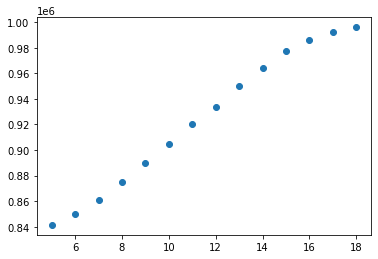

In [133]:
plt.scatter(Y,X)

In [134]:
import math

In [135]:
from scipy.optimize import curve_fit
def F(x,a,b):
    return a*x+b

params = curve_fit(F, xdata=Y, ydata=X)

In [136]:
params

(array([ 13027.72090425, 774762.85246468]),
 array([[  149783.38253452, -1722508.90516021],
        [-1722508.90516021, 22242832.44913608]]))

In [137]:
from matplotlib import pyplot as plt

In [138]:
z=[i for i in range(20)]

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

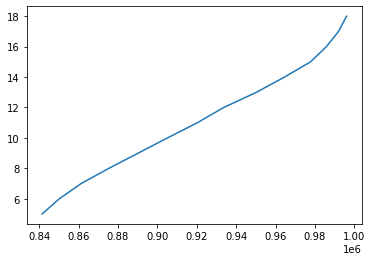

In [139]:
plt.plot(X,Y)
plt.plot(z,z*params[0][0]**2+params[0][1]*z+params[0][2])

In [ ]:
#Code checking if there are indeed 19 instances per city
for v in filtered_data2['METROREG'].unique():
    print(filtered_data2[filtered_data2['METROREG'] == v])

In [ ]:
[0,0,0].count(0)

In [ ]:
def treat_missing(k,t): #t is a threshold for the number of zeros (mising value we allow)
    L1 = list(k.employed_persons)
    L2 = list(k.gdp)
    L3 = list(k.population) 
    
    if L1.count(0)>t,
    

In [ ]:
#need to check if there are zeros in subdataframe
def treat_missing(k):
    #nested helper function
    #needed because .index() doesn't retrieve position for more than one value
    #eg: for l=[0,0,2], l.index(0) returns 0 and not (0,1)
    def get_zeros(k):
        z=[]
        for i in range(len(k)):
            if k[i]==0:
                z.append(i)
        return z  
    #turns the dataframe into lists
    L1 = list(k.employed_persons)
    L2 = list(k.gdp)
    L3 = list(k.population) 
    z1=get_zeros(L1)
    z2=get_zeros(L2)
    z3=get_zeros(L3)
    #for missing single values at either ends 
    
    #employed_persons
    if len(z1) == 1 and z1[0] == 0:
        L1[0] = L1[1] - abs(L1[1]-L1[2])
        k.employed_persons = L1
    if len(z1) == 1 and z1[0] == 18:
        L1[18] = L1[17] + abs(L1[17]-L1[16])
        k.employed_persons = L1
    
    #gdp
    if len(z2) == 1 and z2[0] == 0:
        L2[0] = L2[1] - abs(L2[1]-L2[2])
        k.gdp = L2
    if len(z2) == 1 and z2[0] == 18:
        L2[18] = L2[17] + abs(L2[17]-L2[16])
        k.gdp = L2
    
    #population
    if len(z3) == 1 and z3[0] == 0:
        L3[0] = L3[1] - abs(L3[1]-L3[2])
        k.population = L3
    if len(z3) == 1 and z3[0] == 18:
        L3[18] = L3[17] + abs(L3[17]-L3[16])
        k.population = L3
    #For missing values at ends (more than one)
    #nested function
    #[0,1]->True
    #[0,2]->False
    def evenly_spaced(l):
        for i in range(len(l)-1):
            if abs(l[i]-l[i+1])!=1:
                return False
        return True

    #employed_persons
    if (len(z1) >1) and evenly_spaced(z1) == True and z1[0] == 0:
        for i in reversed(z1):
            L1[i] = L1[i+1] - abs(L1[i+1] - L1[i+2])
        k.employed_persons = L1
    
    #gdp
    if (len(z2) >1) and evenly_spaced(z2) == True and z2[0] == 0:
        for i in reversed(z2):
            L2[i] = L2[i+1] - abs(L2[i+1] - L2[i+2])
        k.gdp = L2
        
    #population
    if (len(z3) >1) and evenly_spaced(z3) == True and z3[0] == 0:
        for i in reversed(z3):
            L3[i] = L3[i+1] - abs(L3[i+1] - L3[i+2])
        k.population = L3
        
    #other end 
    #employed_persons
    if (len(z1) >1) and evenly_spaced(z1) == True and z1[-1] == 18:
        for i in z1:
            L1[i] = L1[i-1] + abs(L1[i-1] - L1[i-2])
        k.employed_persons = L1
    #gdp
    if (len(z2) >1) and evenly_spaced(z2) == True and z2[-1] == 18:
        for i in z2:
            L2[i] = L2[i-1] + abs(L2[i-1] - L2[i-2])
        k.gdp = L2
    #population
    if (len(z3) >1) and evenly_spaced(z3) == True and z3[-1] == 18:
        for i in z3:
            L3[i] = L3[i-1] + abs(L3[i-1] - L3[i-2])
        k.population = L3
    #If values are missing in the middle of the dataframe: -> apply what Simon showed on excel
    #employed_persons
    if ((len(z1) >1) and evenly_spaced(z1) == True) and (z1[-1] != 18 and z1[0] != 0):
        p = L1[z1[0]-1] - L1[z1[-1]+1]
        add = p/(len(z1)+1)
        for i in z1:
            L1[i]=L1[i-1]+add
        k.employed_persons=L1
    #gdp
    if ((len(z2) >1) and evenly_spaced(z2) == True) and (z2[-1] != 18 and z2[0] != 0):
        print(L2)
        print(z2)
        p = L2[z2[0]-1] - L2[z2[-1]+1]
        add = p/(len(z2)+1)
        for i in z2:
            L2[i]=L2[i-1]+add
        k.gdp=L2
    #population
    if ((len(z3) >1) and evenly_spaced(z3) == True) and (z3[-1] != 18 and z3[0] != 0):
        p = L3[z3[0]-1] - L3[z3[-1]+1]
        add = p/(len(z3)+1)
        for i in z3:
            L3[i]=L3[i-1]+add
        k.population=L3
    #more complicated cases
    #0xxx000
    #000xxx0
    #000xxx000
    #3rd helper function for 
    def get_sep(l):
        for i in range(len(l)-1):
            if abs(l[i]-l[i+1])!=1:
                t=(l[i],l[i+1])
        return t
    #0xxx000
    if evenly_spaced(z1) == False and len(z1)>1 and z1[0]==0:
        L1[0] = L1[1] - abs(L1[1]-L1[2])
        p = L1[z1[0]-1] - L1[z1[-1]+1]
        add = p/(len(z1))
        for i in z1[get_sep(z1)[1]:]:
            L1[i]=L1[i-1]+add
        k.employed_persons=L1
    
    #gdp
    if evenly_spaced(z2) == False and len(z2)>1 and z1[0]==0:
        L2[0] = L2[1] - abs(L2[1]-L2[2])
        p = L2[z2[0]-1] - L2[z2[-1]+1]
        add = p/(len(z2))
        for i in z2[get_sep(z2)[1]:]:
            L2[i]=L2[i-1]+add
        k.gdp=L2
    
    #population
    if evenly_spaced(z3) == False and len(z3)>1 and z3[0]==0:
        L3[0] = L3[1] - abs(L3[1]-L3[2])
        p = L3[z3[0]-1] - L3[z3[-1]+1]
        add = p/(len(z3))
        for i in z3[get_sep(z3)[1]:]:
            L3[i]=L3[i-1]+add
        k.population=L3
    
    #000xxx0
    if evenly_spaced(z1) == False and len(z1)>1 and z1[-1]==18:
        L1[18] = L1[17] + abs(L1[17]-L1[16])
        p = L1[z1[0]-1] - L1[z1[-1]+1]
        add = p/(len(z1))
        for i in z1[:get_sep(z1)[1]]:
            L1[i]=L1[i-1]+add
        k.employed_persons=L1
    
    #gdp
    if evenly_spaced(z2) == False and len(z2)>1 and z1[-1]==18:
        L2[0] = L2[1] - abs(L2[1]-L2[2])
        p = L2[z2[0]-1] - L2[z2[-1]+1]
        add = p/(len(z2))
        for i in z2[get_sep(z2)[1]:]:
            L2[i]=L2[i-1]+add
        k.gdp=L2
    
    #population
    if evenly_spaced(z3) == False and len(z3)>1 and z3[-1]==18:
        L3[0] = L3[1] - abs(L3[1]-L3[2])
        p = L3[z3[0]-1] - L3[z3[-1]+1]
        add = p/(len(z3))
        for i in z3[get_sep(z3)[1]:]:
            L3[i]=L3[i-1]+add
        k.population=L3
    
    
        
        
        
        
        
                
        
        
    
    return

In [ ]:
get_sep([1,2,4])[0]

In [ ]:
def get_sep(l):
    for i in range(len(l)-1):
        if abs(l[i]-l[i+1])!=1:
            t=(l[i],l[i+1])
    return t

In [ ]:
 Yo=filtered_data2[filtered_data2['METROREG'] == 'Bergen']

In [ ]:
treat_missing(Yo)

In [ ]:
Yo

In [ ]:
for v in filtered_data2['METROREG'].unique():
    treat_missing(filtered_data2[filtered_data2['METROREG'] == v])

In [ ]:
filtered_data2[20:]

In [ ]:
filtered_data3 = filtered_data2[(filtered_data2['TIME']>=2000) & (filtered_data2['population']>500000) & (filtered_data2['gdp']>40000)]

In [ ]:
filtered_data3 = filtered_data3[filtered_data3['METROREG'].apply(lambda x: len(x) < 27)]

In [ ]:
import geopy
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="Master-Student")
def get_coord(k):
    assert type(k)==str
    return (geolocator.geocode(k).latitude,geolocator.geocode(k).longitude)

In [ ]:
latlong=[0 for i in range(filtered_data3.shape[0])]

In [ ]:
filtered_data3['latitude'] = latlong
filtered_data3['longitude'] = latlong

In [ ]:
filtered_data3

In [ ]:
d={}
for i in sorted(set(list(filtered_data3.METROREG))):
    print(i)
    d[i]=get_coord(i)

In [ ]:
for i in range(len(list(d.keys()))):
    for idx, row in filtered_data3.iterrows():
            filtered_data3.loc[idx,'latitude'] = list(d.values())[i][0]
            filtered_data3.loc[idx,'longitude'] = list(d.values())[i][1]

In [ ]:
d2=dict(filtered_data3['METROREG'].value_counts())

In [ ]:
d2

In [ ]:
for i in d2.keys():
    if d2[i]<10:
        filtered_data3=filtered_data3[filtered_data3.METROREG!=i]

In [ ]:
filtered_data3